## 題目: 同樣使用銀行定存的範例，但是請使用並比較 sklearn 和 tensorflow 的 neural network 去解，並與 SVM 做比較。
    姓名: 施宏勲
    學號: 5114029040
    註記: 已在 HW -- Neural Networks.py 實作完成後搬來 jupyter 完成筆記
---

## 讀取前處理後的資料

In [14]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv("../week7_hw_data_processing/output/feature_select_by_myself.csv")
X = data.drop("y", axis=1)
y = data["y"]

- 分割資料成訓練集和測試集

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1000
)

---

## 1. SVM (GridSearchCV) 訓練

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# SVM 需要將 y 轉換為 -1 和 1
y_train_svm = y_train.replace({0: -1, 1: 1})
y_test_svm = y_test.replace({0: -1, 1: 1})

param_grid = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 5, 10],
    "gamma": ["scale", 0.01, 0.1],
}

gs = GridSearchCV(
    SVC(probability=True, random_state=1000),
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2,
)

# 計算訓練時間
import time

start_svm = time.time()
gs.fit(X_train, y_train_svm)
train_svm = time.time() - start_svm

print(f"\nGridSearchCV 完成, 耗時: {train_svm:.3f} 秒")
print(f"最佳 SVM 參數: {gs.best_params_}")
print(f"最佳交叉驗證分數: {gs.best_score_:.4f}")

# 使用最佳模型預測
best_svm = gs.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

# 計算指標
acc_svm = accuracy_score(y_test_svm, y_pred_svm)
prec_svm = precision_score(y_test_svm, y_pred_svm)
rec_svm = recall_score(y_test_svm, y_pred_svm)
f1_svm = f1_score(y_test_svm, y_pred_svm)
auc_svm = roc_auc_score(y_test_svm, y_proba_svm)

print(f"\nSVM 效能:")
print(f"訓練時間: {train_svm:.3f} 秒")
print(f"Accuracy: {acc_svm:.4f}")
print(f"Precision: {prec_svm:.4f}")
print(f"Recall: {rec_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"AUC: {auc_svm:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

GridSearchCV 完成, 耗時: 1613.065 秒
最佳 SVM 參數: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
最佳交叉驗證分數: 0.8937

SVM 效能:
訓練時間: 1613.065 秒
Accuracy: 0.8924
Precision: 0.6862
Recall: 0.1841
F1-Score: 0.2903
AUC: 0.6305


---

## 2. sklearn MLPClassifier (Neural Network) 訓練
#### 使用兩層的 hidden layer(64, 32)


In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='tanh',
    solver='sgd',
    learning_rate_init=0.1,
    max_iter=10000,
    random_state=1000,
    verbose=False
)

start_mlp = time.time()
mlp.fit(X_train, y_train)
train_mlp = time.time() - start_mlp

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

print(f"\nsklearn MLP 效能 (架構: (64, 32)):")
print(f"訓練時間: {train_mlp:.3f} 秒")
print(f"Accuracy: {acc_mlp:.4f}")
print(f"Precision: {prec_mlp:.4f}")
print(f"Recall: {rec_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")
print(f"AUC: {auc_mlp:.4f}")


sklearn MLP 效能 (架構: (64, 32)):
訓練時間: 23.709 秒
Accuracy: 0.8698
Precision: 0.4087
Recall: 0.1989
F1-Score: 0.2676
AUC: 0.6736


---

## 3. TensorFlow Keras Neural Network (Functional API) 訓練
#### 一樣也使用兩層的 hidden layer(64, 32)

In [10]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

# Step 1: Defining input
visible = Input(shape=(X_train.shape[1],))

# Step 2: Connecting layers - 使用 (64, 32) 架構
hidden1 = Dense(64, activation='tanh')(visible)
hidden2 = Dense(32, activation='tanh')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

# Step 3: Creating the model
model = Model(inputs=visible, outputs=output)

model.compile(
    optimizer='RMSprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n模型架構:")
model.summary()

# 訓練模型
start_tf = time.time()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
train_tf = time.time() - start_tf

# 預測
y_proba_tf = model.predict(X_test, verbose=0).flatten()
y_pred_tf = (y_proba_tf > 0.5).astype(int)

acc_tf = accuracy_score(y_test, y_pred_tf)
prec_tf = precision_score(y_test, y_pred_tf)
rec_tf = recall_score(y_test, y_pred_tf)
f1_tf = f1_score(y_test, y_pred_tf)
auc_tf = roc_auc_score(y_test, y_proba_tf)

print(f"\nTensorFlow Keras NN 效能 (架構: (64, 32)):")
print(f"訓練時間: {train_tf:.3f} 秒")
print(f"Accuracy: {acc_tf:.4f}")
print(f"Precision: {prec_tf:.4f}")
print(f"Recall: {rec_tf:.4f}")
print(f"F1-Score: {f1_tf:.4f}")
print(f"AUC: {auc_tf:.4f}")


模型架構:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense (Dense)               (None, 64)                1472      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
905/905 [==============================] - 4s 3ms/step - loss: 0.3150 - accuracy: 0.8896 - val_loss: 0.3289 - val_accuracy: 0.8831
Epoch 2/100
905/905 [====================

---

## 3. 模型比較表格

In [11]:
comparison = pd.DataFrame(
    {
        "模型": [
            "SVM (GridSearchCV)",
            "sklearn MLP (64,32)",
            "TensorFlow Keras (64,32)",
        ],
        "訓練時間 (秒)": [f"{train_svm:.3f}", f"{train_mlp:.3f}", f"{train_tf:.3f}"],
        "Accuracy": [f"{acc_svm:.4f}", f"{acc_mlp:.4f}", f"{acc_tf:.4f}"],
        "Precision": [f"{prec_svm:.4f}", f"{prec_mlp:.4f}", f"{prec_tf:.4f}"],
        "Recall": [f"{rec_svm:.4f}", f"{rec_mlp:.4f}", f"{rec_tf:.4f}"],
        "F1-Score": [f"{f1_svm:.4f}", f"{f1_mlp:.4f}", f"{f1_tf:.4f}"],
        "AUC": [f"{auc_svm:.4f}", f"{auc_mlp:.4f}", f"{auc_tf:.4f}"],
    }
)

print("\n")
print(comparison.to_string(index=False))

# 找出各指標最佳模型
best_models = {
    "Accuracy": comparison.loc[comparison["Accuracy"].astype(float).idxmax(), "模型"],
    "Precision": comparison.loc[comparison["Precision"].astype(float).idxmax(), "模型"],
    "Recall": comparison.loc[comparison["Recall"].astype(float).idxmax(), "模型"],
    "F1-Score": comparison.loc[comparison["F1-Score"].astype(float).idxmax(), "模型"],
    "AUC": comparison.loc[comparison["AUC"].astype(float).idxmax(), "模型"],
}

print("\n各指標最佳模型:")
for metric, model_name in best_models.items():
    print(f"  {metric}: {model_name}")



                      模型 訓練時間 (秒) Accuracy Precision Recall F1-Score    AUC
      SVM (GridSearchCV) 1613.065   0.8924    0.6862 0.1841   0.2903 0.6305
     sklearn MLP (64,32)   23.709   0.8698    0.4087 0.1989   0.2676 0.6736
TensorFlow Keras (64,32)  248.936   0.8874    0.6098 0.1619   0.2558 0.7179

各指標最佳模型:
  Accuracy: SVM (GridSearchCV)
  Precision: SVM (GridSearchCV)
  Recall: sklearn MLP (64,32)
  F1-Score: SVM (GridSearchCV)
  AUC: TensorFlow Keras (64,32)


---

## 4. TensorFlow 訓練 History

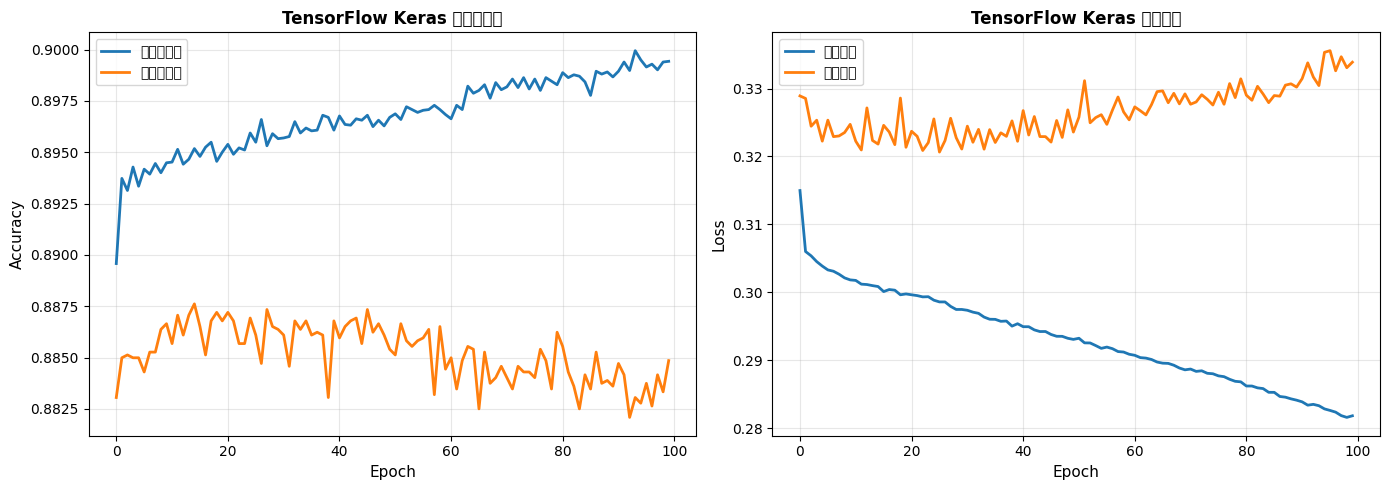

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 準確率
axes[0].plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)
axes[0].set_xlabel("Epoch", fontsize=11)
axes[0].set_ylabel("Accuracy", fontsize=11)
axes[0].set_title("TensorFlow Keras Train Accuracy", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 損失
axes[1].plot(history.history["loss"], label="Train Loss", linewidth=2)
axes[1].plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
axes[1].set_xlabel("Epoch", fontsize=11)
axes[1].set_ylabel("Loss", fontsize=11)
axes[1].set_title("TensorFlow Keras Train Loss", fontsize=12, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 結論

#### 架構選擇
- 我手選資料集X有 22 個特徵，我選用 **(64, 32)** 兩層的 hidden layer，sklearn MLP 與 TensorFlow Keras 使用相同架構比較

#### 效能比較
 - **SVM**: Accuracy (0.8924) 和 Precision (0.6862) 最佳，訓練時間最長 (1613s)
 - **sklearn MLP**: Recall (0.1989) 最佳，訓練最快 (24s)
 - **TensorFlow Keras**: AUC (0.7179) 最佳，綜合也不差 (249s)